In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import random
from sklearn.base import clone
from decision_tree import *
from ga_methods import *
from tqdm import tqdm
from sklearn import tree
import copy

In [17]:
def load_data(dataset_name, test_size=0.2, random_state=1):
    if dataset_name == 'mnist':
        data = load_digits()
    elif dataset_name == 'breast_cancer':
        data = load_breast_cancer()
    elif dataset_name == 'iris':
        data = load_iris()
    elif dataset_name == 'wine':
        data = load_wine()
    elif dataset_name == 'abalone':
        df = pd.read_csv('data/abalone.csv')
        df['Sex'] = df['Sex'].apply(lambda x: 0 if 'M' else 1)
        labels = []
        for r in df['Rings']:
            if 0<=r and r<=7:
                label = 1
            elif 8<=r and r<=10:
                label = 2
            elif 11<=r and r<=15:
                label = 3
            elif r>15:
                label = 4
            labels.append(label)
        class Object(object):
            pass
        data = Object()
        data.data = np.asarray(df.loc[:, df.columns!='Rings'])
        data.target = np.asarray(labels)
    X = data.data
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('Train: ', X_train.shape, ' | Test: ', X_test.shape)
    print('Train labels: ', np.unique(y_train, return_counts=True))
    print('Test labels: ', np.unique(y_test, return_counts=True))
    return X_train, X_test, y_train, y_test

In [19]:
def fit_decision_tree_max_3(X_train, X_test, y_train, y_test):
    clf = ClassificationTree(max_depth=3)
    clf.fit(X_train, y_train)
    dectree_max3_acc = eval_model(clf, X_test, y_test)
    print('Decision tree max depth 3 accuracy: ', round_acc(dectree_max3_acc))
    return dectree_max3_acc

def fit_decision_tree_free(X_train, X_test, y_train, y_test):
    clf = ClassificationTree()
    clf.fit(X_train, y_train)
    dectree_free_acc = eval_model(clf, X_test, y_test)
    print('Decision tree free accuracy: ', round_acc(dectree_free_acc))
    return dectree_free_acc

def fit_bagging(X_train, X_test, y_train, y_test):
    clf = BaggingClassifier()
    clf.fit(X_train, y_train)
    bagging_acc = eval_model(clf, X_test, y_test)
    print('Bagging accuracy: ', round_acc(bagging_acc))
    return bagging_acc

def fit_adaboost(X_train, X_test, y_train, y_test):
    clf = AdaBoostClassifier()
    clf.fit(X_train, y_train)
    adaboost_acc = eval_model(clf, X_test, y_test)
    print('Adaboost accuracy: ', round_acc(adaboost_acc))
    return adaboost_acc

def round_acc(acc):
    return round(acc*100, 2)

def get_bagging_results(tree_list, X, y):
    results = []
    preds = bagging_predict(tree_list, X)
    return accuracy_score(y, preds)

def experiment(dataset_name, 
               log_path,
               viz_path,
               n_crossover,
               n_mutate,
               n_select,
               selection='tournament', 
               test_size=0.2, 
               random_state=1, 
               tournament_size=0.1,
               step=200,
               x=1000,
               gen_gap=0.25):
    X_train, X_test, y_train, y_test = load_data(dataset_name)
    dectree_max3_acc = fit_decision_tree_max_3(X_train, X_test, y_train, y_test)
    dectree_tree_acc = fit_decision_tree_free(X_train, X_test, y_train, y_test)
    bagging_acc = fit_bagging(X_train, X_test, y_train, y_test)
    adaboost_acc = fit_adaboost(X_train, X_test, y_train, y_test)
    # initialize trees
    trees = [gen_new_binary_tree(X_train, y_train) for i in range(p)]
    
    # genetic algorithm with overlapping generations
    best_gen = []
    best_acc, best_idx = 0, 0
    top_5_acc, max_acc, ga_bagging_acc = [], [], []
    depth, size = [], []
    best_payoff, mean_payoff = [], []
    for i in tqdm(range(step)):
        # evaluate trees
        scaled_payoffs = [get_tree_scaled_payoff(j, trees, X_train, y_train, x) for j in range(len(trees))]
        # replace 25% worst trees
        payoff_threshold = np.quantile(scaled_payoffs, gen_gap)
        for j, scaled_payoff in enumerate(scaled_payoffs):
            if scaled_payoff <= payoff_threshold:
                tree = gen_new_binary_tree(X_train, y_train)
                trees[j] = tree
                # update payoff
                scaled_payoffs[j] = get_tree_scaled_payoff(j, trees, X_train, y_train, x)
        best_payoff.append(max(scaled_payoffs))
        mean_payoff.append(sum(scaled_payoffs)/len(scaled_payoffs))
        # roulette wheel selection
        if selection == 'tournament':
            next_gen_trees = tournament(trees, scaled_payoffs, n_select, tournament_size)
        elif selection == 'roulette':
            next_gen_trees = roulette_wheel_selection(trees, scaled_payoffs, n_select)

        # crossover
        crossover_trees = []
        select_indices = np.asarray(scaled_payoffs).argsort()[-n_crossover:][::-1]
        for j in select_indices:
            crossover_trees.append(trees[j])
        random.shuffle(crossover_trees)
        for j in range(0, len(crossover_trees), 2):
            tree1 = crossover_trees[j]
            tree2 = crossover_trees[j+1]
            new_tree1, new_tree2 = crossover(tree1, tree2)
            crossover_trees[j] = new_tree1
            crossover_trees[j+1] = new_tree2
        next_gen_trees.extend(crossover_trees)
        # mutate
        select_indices = random.sample(range(len(next_gen_trees)), n_mutate)
        for j in select_indices:
            try:
                mutate(next_gen_trees[j])
            except AttributeError as e:
                print(next_gen_trees[j].root.correct, next_gen_trees[j].root.incorrect)
                raise e
        # get acc
        iter_acc = [eval_model(tree, X_test, y_test) for tree in next_gen_trees]
        iter_depth = [tree.get_depth() for tree in next_gen_trees]
        iter_size = [tree.get_size() for tree in next_gen_trees]
        iter_df = pd.DataFrame({'acc': iter_acc, 'depth': iter_depth, 'size': iter_size, 'index': range(p)})
        top_5 = iter_df.nlargest(5, 'acc')
        top_5_trees = [next_gen_trees[j] for j in top_5['index']]
        trees = next_gen_trees[:]
        if best_acc < top_5['acc'].max():
            best_acc = top_5['acc'].max()
            best_gen = [copy.deepcopy(tree) for tree in trees]
            best_index = iter_df.index[iter_df['acc'] == best_acc].tolist()[0]
            best_depth = iter_depth[best_index]
        top_5_acc.append(round(top_5['acc'].mean()*100, 2))
        max_acc.append(round(top_5['acc'].max()*100, 2))
        ga_bagging_acc.append(get_bagging_results(top_5_trees, X_test, y_test))
        depth.append(top_5['depth'].mean())
        size.append(top_5['size'].mean())
    print(f"Best accuracy: {round(best_acc*100, 2)}")
    with open(log_path, 'a+') as f:
        f.write(f"Dataset: {dataset_name}\n")
        f.write(f"Decision tree max depth 3 accuracy: {round_acc(dectree_max3_acc)}\n")
        f.write(f"Decision tree free accuracy: {round_acc(dectree_tree_acc)}\n")
        f.write(f"Bagging accuracy: {round_acc(bagging_acc)}\n")
        f.write(f"AdaBoost accuracy: {round_acc(adaboost_acc)}\n")
        f.write(f"GA tree accuracy: {round_acc(best_acc)}\n")
        f.write(f"Bagging GA tree accuracy: {round_acc(max(ga_bagging_acc))}\n")
        f.write(f"Best tree depth: {best_depth}\n")
        f.write("========================================================================\n")
    x_axis = range(step)
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    plt.plot(x_axis, max_acc, label = "max_acc")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(x_axis, best_payoff, label = 'best payoff')
    plt.plot(x_axis, mean_payoff, label = 'mean payoff')
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(x_axis, depth, label = 'depth')
    plt.plot(x_axis, size, label = 'size')
    plt.legend()
    plt.savefig(viz_path + f"_{dataset_name}.png")
    
def run_experiments(p, r, m, step, x, gen_gap, selection, test_size, random_state, tournament_size):
    n_crossover = int(r*p)
    assert n_crossover%2==0, "Odd n_crossover"
    n_select = p - n_crossover
    n_mutate = int(m*p)
    print(f"Select {n_select} | Crossover {n_crossover} | Mutate {n_mutate}\n")
    log_path = f"log/p{p}_r{r}_m{step}_x{x}_gengap{gen_gap}_selection{selection}.txt"
    viz_path = f"viz/p{p}_r{r}_m{step}_x{x}_gengap{gen_gap}_selection{selection}"
    with open(log_path, 'w') as f:
        f.write(f"p: {p} | r: {r} | m: {m} | step: {step} | x: {x} | gen gap: {gen_gap} | selection: {selection}\n")
    for dataset_name in ['iris', 'wine', 'breast_cancer', 'abalone', 'mnist']:
        print(f"Dataset: {dataset_name}")
        experiment(dataset_name, 
                   log_path, 
                   viz_path,
                   n_crossover,
                   n_mutate,
                   n_select,
                   selection, 
                   test_size, 
                   random_state, 
                   tournament_size,
                   step,
                   x,
                   gen_gap)
        print("==============================================================================")

/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])
/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Select 14 | Crossover 186 | Mutate 1

Dataset: iris
Train:  (120, 4)  | Test:  (30, 4)
Train labels:  (array([0, 1, 2]), array([39, 37, 44]))
Test labels:  (array([0, 1, 2]), array([11, 13,  6]))
Decision tree max depth 3 accuracy:  93.33
Decision tree free accuracy:  93.33
Bagging accuracy:  96.67
Adaboost accuracy:  96.67


100%|██████████| 200/200 [00:36<00:00,  5.42it/s]


Best accuracy: 100.0
Dataset: wine
Train:  (142, 13)  | Test:  (36, 13)
Train labels:  (array([0, 1, 2]), array([45, 58, 39]))
Test labels:  (array([0, 1, 2]), array([14, 13,  9]))


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree max depth 3 accuracy:  97.22


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree free accuracy:  97.22
Bagging accuracy:  91.67
Adaboost accuracy:  83.33


100%|██████████| 200/200 [00:43<00:00,  4.62it/s]
/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Best accuracy: 91.67
Dataset: breast_cancer
Train:  (455, 30)  | Test:  (114, 30)
Train labels:  (array([0, 1]), array([170, 285]))
Test labels:  (array([0, 1]), array([42, 72]))
Decision tree max depth 3 accuracy:  94.74


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree free accuracy:  92.11
Bagging accuracy:  94.74
Adaboost accuracy:  92.98


100%|██████████| 200/200 [01:52<00:00,  1.77it/s]
/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Best accuracy: 92.11
Dataset: abalone
Train:  (3341, 8)  | Test:  (836, 8)
Train labels:  (array([1, 2, 3, 4]), array([ 672, 1509,  948,  212]))
Test labels:  (array([1, 2, 3, 4]), array([167, 382, 238,  49]))
Decision tree max depth 3 accuracy:  57.66


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


None None
Decision tree free accuracy:  55.02
Bagging accuracy:  58.01
Adaboost accuracy:  58.73


100%|██████████| 200/200 [05:13<00:00,  1.57s/it]


Best accuracy: 55.98
Dataset: mnist
Train:  (1437, 64)  | Test:  (360, 64)
Train labels:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([135, 147, 141, 142, 143, 152, 144, 142, 145, 146]))
Test labels:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([43, 35, 36, 41, 38, 30, 37, 37, 29, 34]))


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree max depth 3 accuracy:  69.72


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree free accuracy:  90.0
Bagging accuracy:  95.28
Adaboost accuracy:  25.56


100%|██████████| 200/200 [07:47<00:00,  2.34s/it]


Best accuracy: 25.0


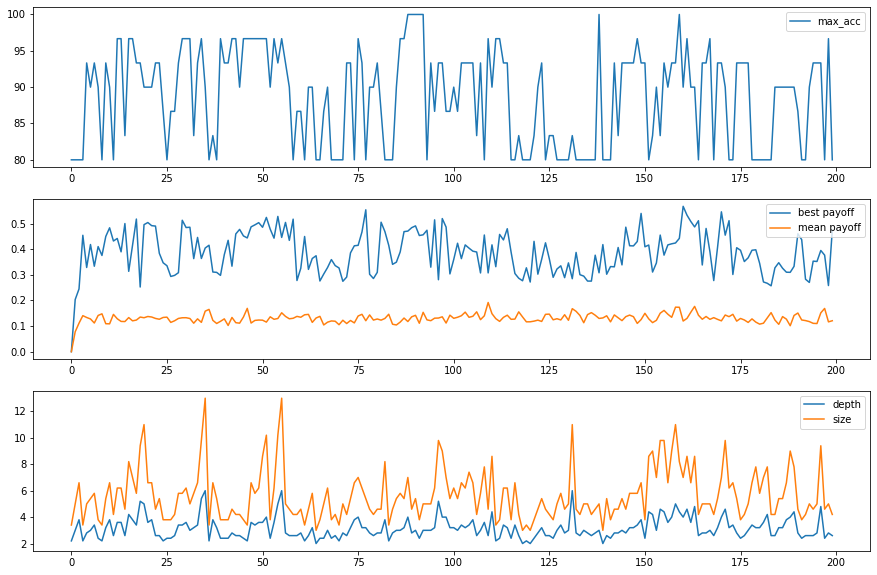

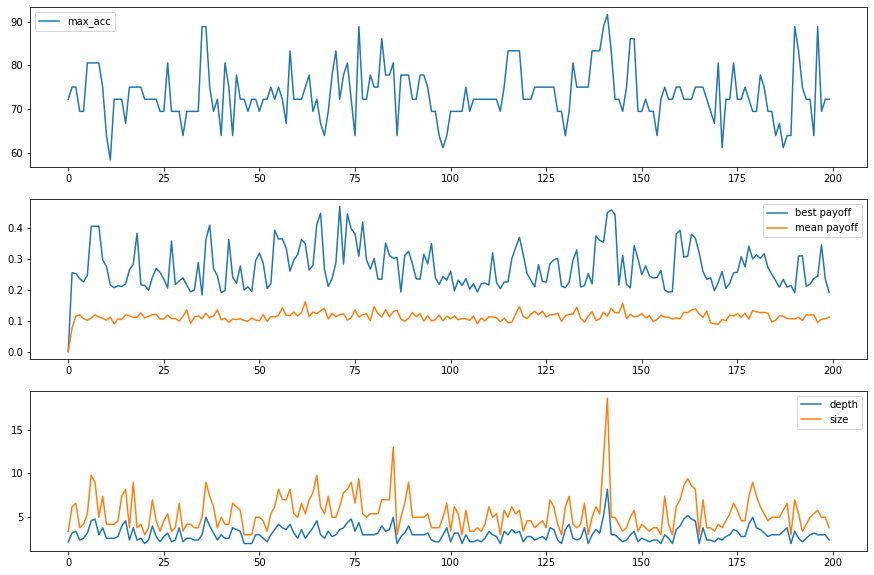

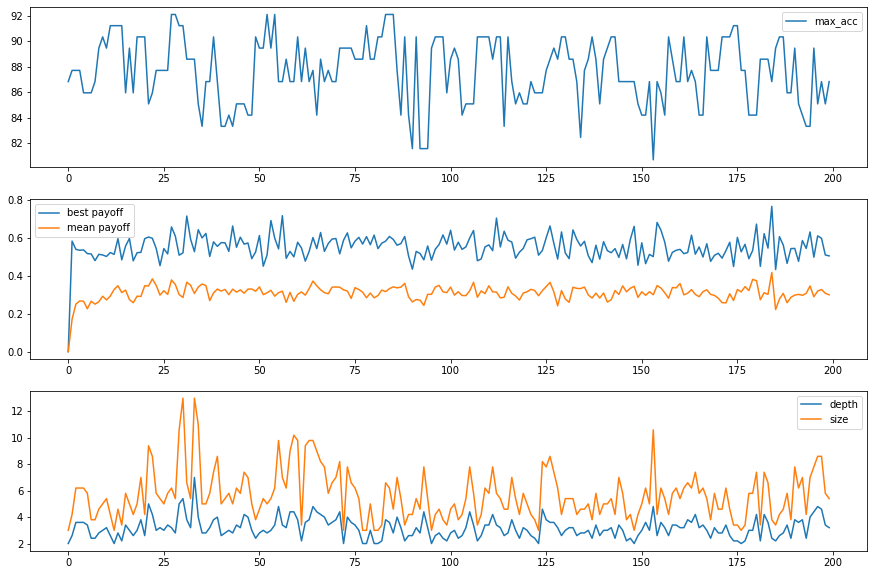

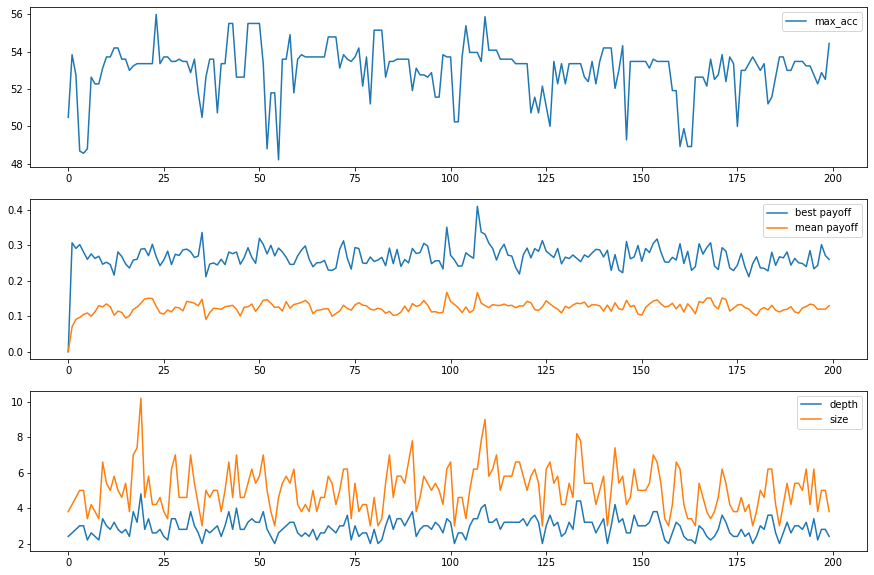

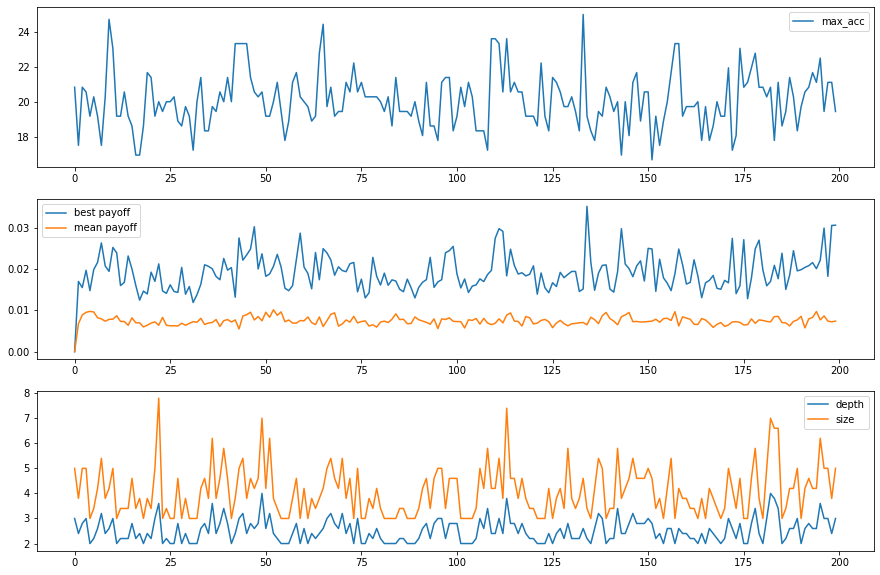

In [20]:
p = 200     # number of hypotheses
r = 0.93    # fraction of crossover
m = 0.005   # mutation rate
step = 200  # number of steps
x = 1000    # size factor
gen_gap = 0.25 # generation gap
selection = "tournament"
test_size = 0.2
random_state = 54
tournament_size = 0.1
run_experiments(p, r, m, step, x, gen_gap, selection, test_size, random_state, tournament_size)

In [ ]:
p = 200     # number of hypotheses
r = 0.93    # fraction of crossover
m = 0.005   # mutation rate
step = 200  # number of steps
x = 1000    # size factor
gen_gap = 0.25 # generation gap
selection = "roulette"
test_size = 0.2
random_state = 54
tournament_size = 0.1
run_experiments(p, r, m, step, x, gen_gap, selection, test_size, random_state, tournament_size)

/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])
/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Select 14 | Crossover 186 | Mutate 1

Dataset: iris
Train:  (120, 4)  | Test:  (30, 4)
Train labels:  (array([0, 1, 2]), array([39, 37, 44]))
Test labels:  (array([0, 1, 2]), array([11, 13,  6]))
Decision tree max depth 3 accuracy:  93.33
Decision tree free accuracy:  93.33
Bagging accuracy:  96.67
Adaboost accuracy:  96.67


100%|██████████| 200/200 [00:36<00:00,  5.55it/s]
/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Best accuracy: 100.0
Dataset: wine
Train:  (142, 13)  | Test:  (36, 13)
Train labels:  (array([0, 1, 2]), array([45, 58, 39]))
Test labels:  (array([0, 1, 2]), array([14, 13,  9]))
Decision tree max depth 3 accuracy:  97.22


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree free accuracy:  97.22
Bagging accuracy:  94.44
Adaboost accuracy:  83.33


100%|██████████| 200/200 [00:42<00:00,  4.73it/s]
/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Best accuracy: 97.22
Dataset: breast_cancer
Train:  (455, 30)  | Test:  (114, 30)
Train labels:  (array([0, 1]), array([170, 285]))
Test labels:  (array([0, 1]), array([42, 72]))
Decision tree max depth 3 accuracy:  94.74


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree free accuracy:  92.11
Bagging accuracy:  94.74
Adaboost accuracy:  92.98


100%|██████████| 200/200 [01:50<00:00,  1.81it/s]
/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Best accuracy: 93.86
Dataset: abalone
Train:  (3341, 8)  | Test:  (836, 8)
Train labels:  (array([1, 2, 3, 4]), array([ 672, 1509,  948,  212]))
Test labels:  (array([1, 2, 3, 4]), array([167, 382, 238,  49]))
Decision tree max depth 3 accuracy:  57.66


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


None None
Decision tree free accuracy:  55.02
Bagging accuracy:  57.66
Adaboost accuracy:  58.73


100%|██████████| 200/200 [05:13<00:00,  1.57s/it]


Best accuracy: 56.34
Dataset: mnist
Train:  (1437, 64)  | Test:  (360, 64)
Train labels:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([135, 147, 141, 142, 143, 152, 144, 142, 145, 146]))
Test labels:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([43, 35, 36, 41, 38, 30, 37, 37, 29, 34]))


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree max depth 3 accuracy:  69.72


/home/giang/Projects/Gaen/evolutionary-boosting/decision_tree.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


Decision tree free accuracy:  90.0
Bagging accuracy:  95.56
Adaboost accuracy:  25.56


 10%|▉         | 19/200 [00:43<06:39,  2.21s/it]

In [ ]:
p = 200     # number of hypotheses
r = 0.93    # fraction of crossover
m = 0.005   # mutation rate
step = 200  # number of steps
x = 100    # size factor
gen_gap = 0.25 # generation gap
selection = "tournament"
test_size = 0.2
random_state = 54
tournament_size = 0.1
run_experiments(p, r, m, step, x, gen_gap, selection, test_size, random_state, tournament_size)